## Notebooks for workload prediction tests
### Using different sklearn libraries

Bytte till notebooks för de kändes lättare...

This is just for prediction tests!!

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression  

import requests

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from numpy import mean
from numpy import std
from scipy.fft import fft
import seaborn as sns


### Access Target_device data

In [20]:

QuerytoolBASE = "http://127.0.0.1:5000/"
response = requests.get(QuerytoolBASE+"databaseservice",json={"start_date": "1998"})
data_result = response.json()


### Preprocess 

,total_load
timestamp,
1998-05-01 00:00:02,1
1998-05-01 00:00:03,4
1998-05-01 00:00:04,8
1998-05-01 00:00:05,25
1998-05-01 00:00:06,31


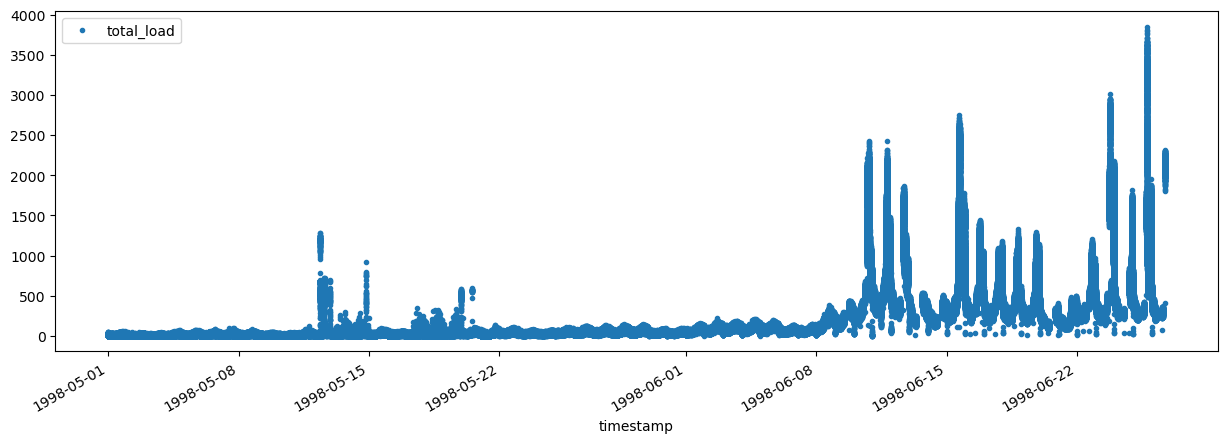

In [21]:
#historical_df = pd.DataFrame(data_result, columns=['timestamp', 'average_load', 'total_load', 'instances'])
historical_df = pd.DataFrame(data_result, columns=['timestamp','requests'])

historical_df['timestamp'] = pd.to_datetime(historical_df['timestamp'],format='%a, %d %b %Y %H:%M:%S GMT') 
historical_df['total_load'] = historical_df['requests'].astype(int)
historical_df = historical_df.set_index("timestamp")
#historical_df =historical_df.drop(columns=[ 'average_load', 'instances'])
historical_df =historical_df.drop(columns=['requests'])
historical_df.plot(style=".",figsize=(15,5))
historical_df.head()
# Resample the data per hour, round to nearest hour, and sum the total_load


## Delete outliers


<Axes: xlabel='timestamp'>

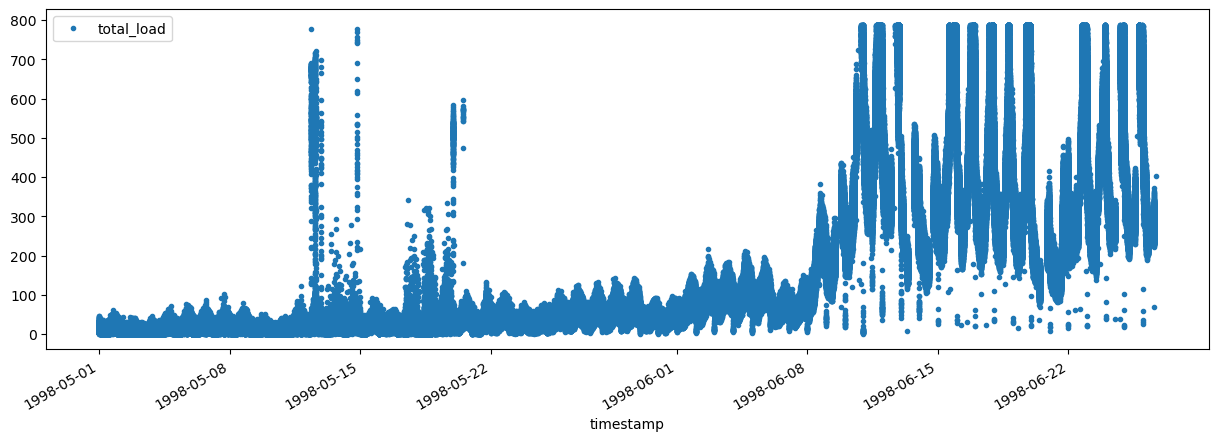

In [22]:
# Assuming df is your DataFrame containing the data

Q1 = historical_df['total_load'].quantile(0.35)
Q3 = historical_df['total_load'].quantile(0.90)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = historical_df[(historical_df['total_load'] >= lower_bound) & (historical_df['total_load'] <= upper_bound)]

df_filtered.plot(style=".",figsize=(15,5))


<Axes: xlabel='timestamp'>

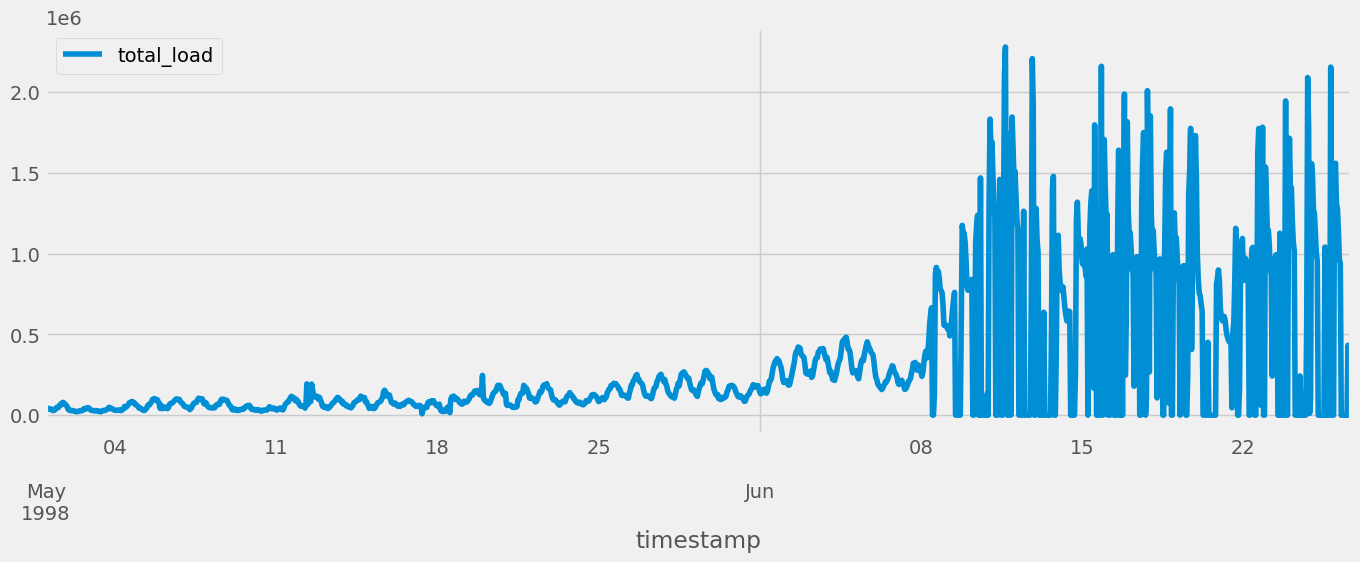

In [73]:
hourly_sum = df_filtered.resample('H').sum()
hourly_sum.plot(figsize=(15,5))



# XGBoost prediction model

### Train/ Test Split

In [39]:
#Importing libs from tutorial
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

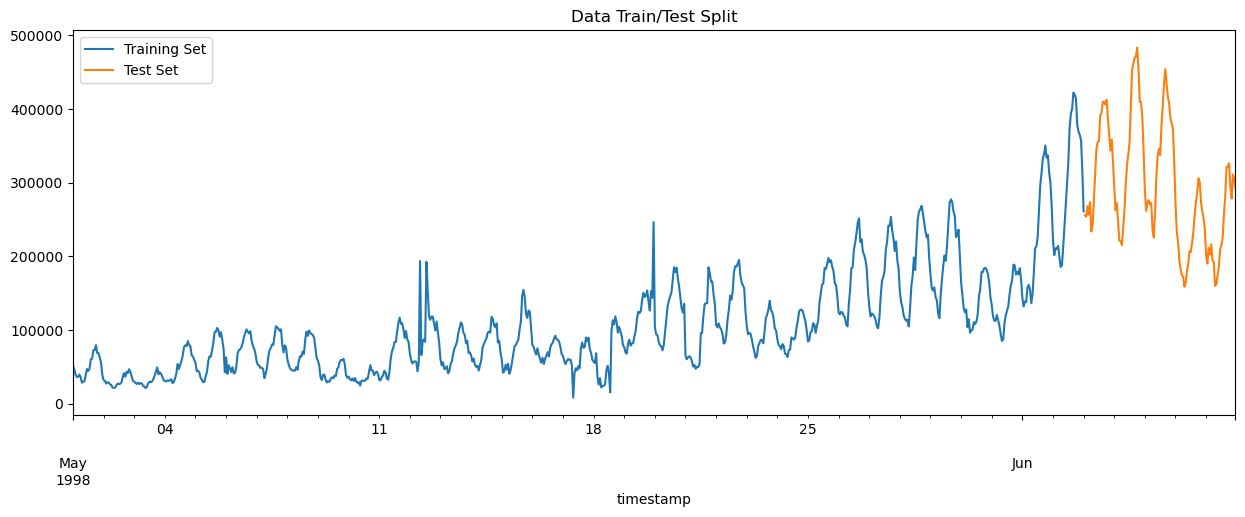

In [30]:
train = hourly_sum.loc[hourly_sum.index <= "1998-06-03 00:00:00"]
test = hourly_sum.loc[(hourly_sum.index > "1998-06-03 00:00:00") & (hourly_sum.index < "1998-06-08 00:00:00")]
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

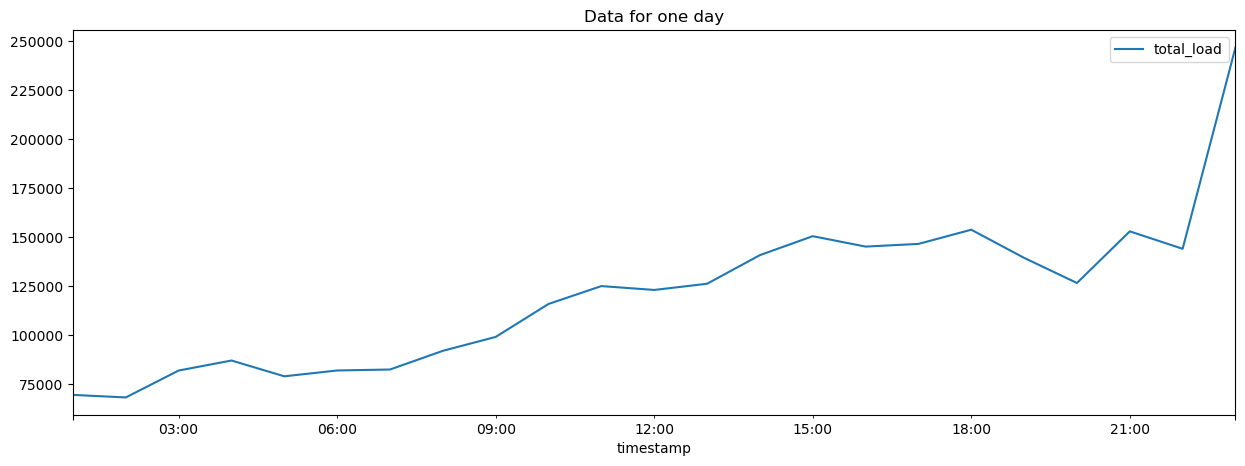

In [34]:
hourly_sum.loc[(hourly_sum.index > '1998-05-19 00:00:00') & (hourly_sum.index < '1998-05-20 00:00:00')] \
    .plot(figsize=(15, 5), title='Data for one day')
plt.show()

In [48]:

def create_features_xgboost(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
   #df['minute'] = df.index.minute NOT NECESSARY
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df

df = create_features_xgboost(hourly_sum)
df

,total_load,hour,dayofweek
timestamp,,,
1998-05-01 00:00:00,51621,0,4
1998-05-01 01:00:00,46813,1,4
1998-05-01 02:00:00,39482,2,4
1998-05-01 03:00:00,36221,3,4
1998-05-01 04:00:00,36270,4,4
...,...,...,...
1998-06-26 12:00:00,0,12,4
1998-06-26 13:00:00,433033,13,4
1998-06-26 14:00:00,0,14,4


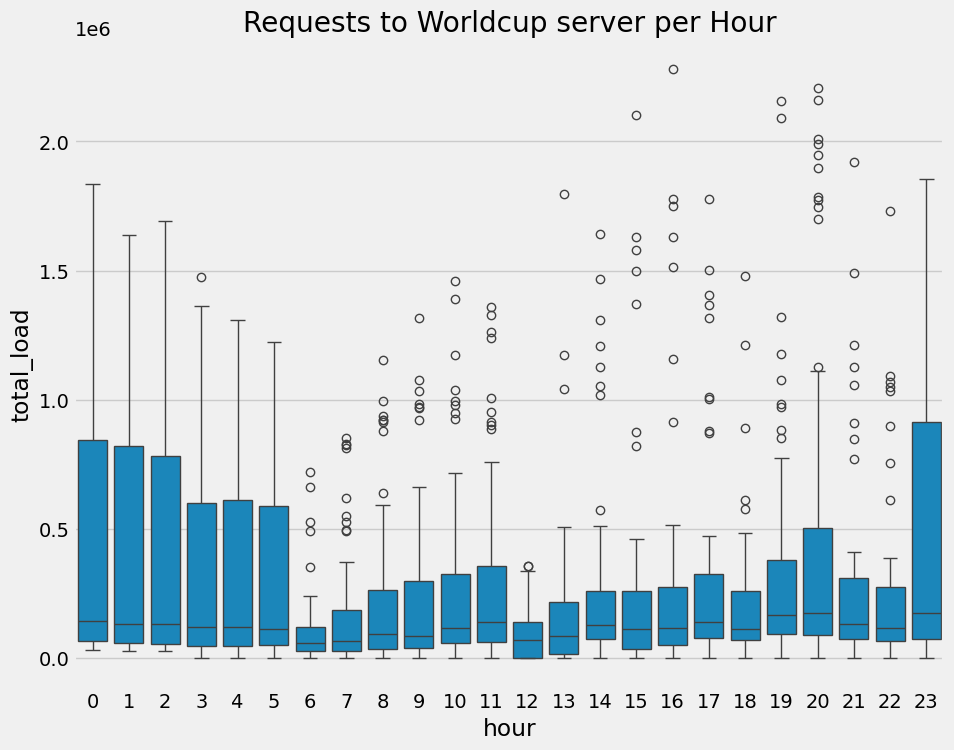

In [40]:
# Visualize

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='total_load')
ax.set_title('Requests to Worldcup server per Hour')
plt.show()

In [41]:
train = create_features_xgboost(train)
test = create_features_xgboost(test)

FEATURES = ['hour', 'dayofweek']
TARGET = 'total_load'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [42]:
reg = xgb.XGBRegressor(n_estimators = 2000, early_stopping_rounds = 50,learning_rate=0.01,
        enable_categorical = True)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:71037.07362	validation_1-rmse:207781.18612


[100]	validation_0-rmse:61105.75393	validation_1-rmse:206983.55695
[131]	validation_0-rmse:60251.05565	validation_1-rmse:207071.83856


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature importances

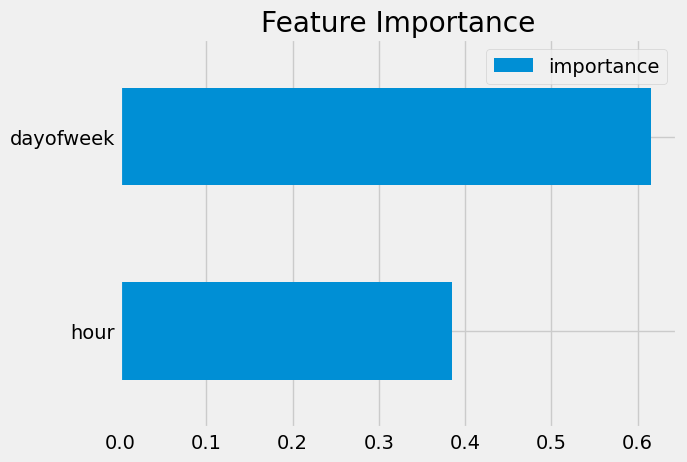

In [43]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

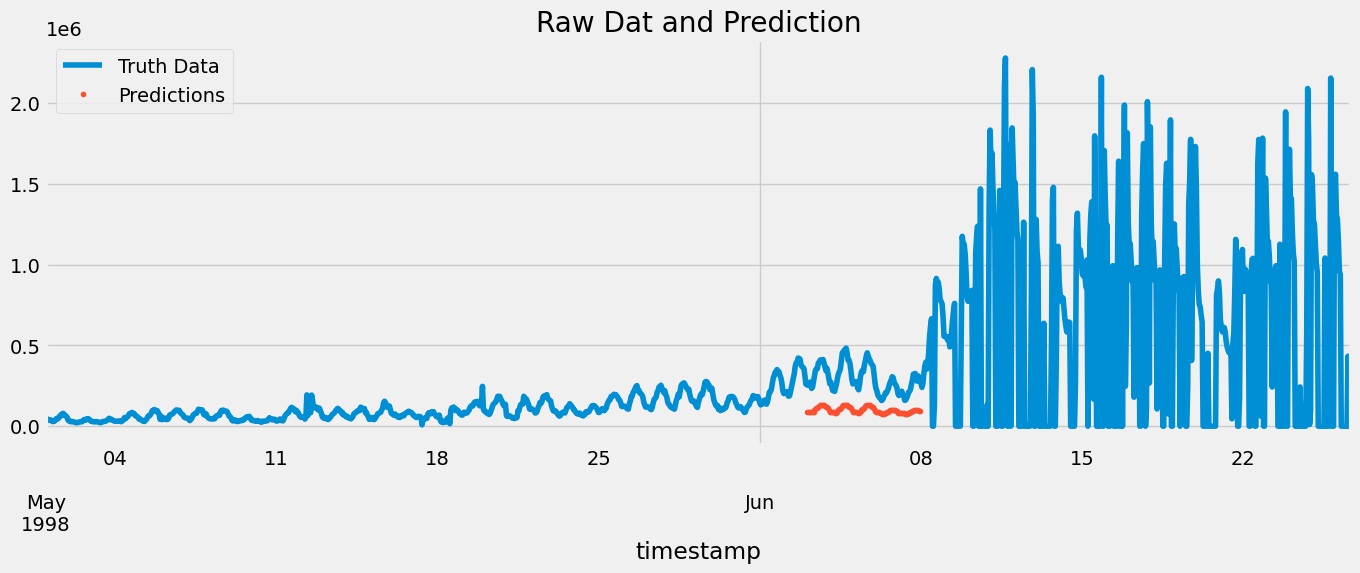

In [44]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['total_load']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


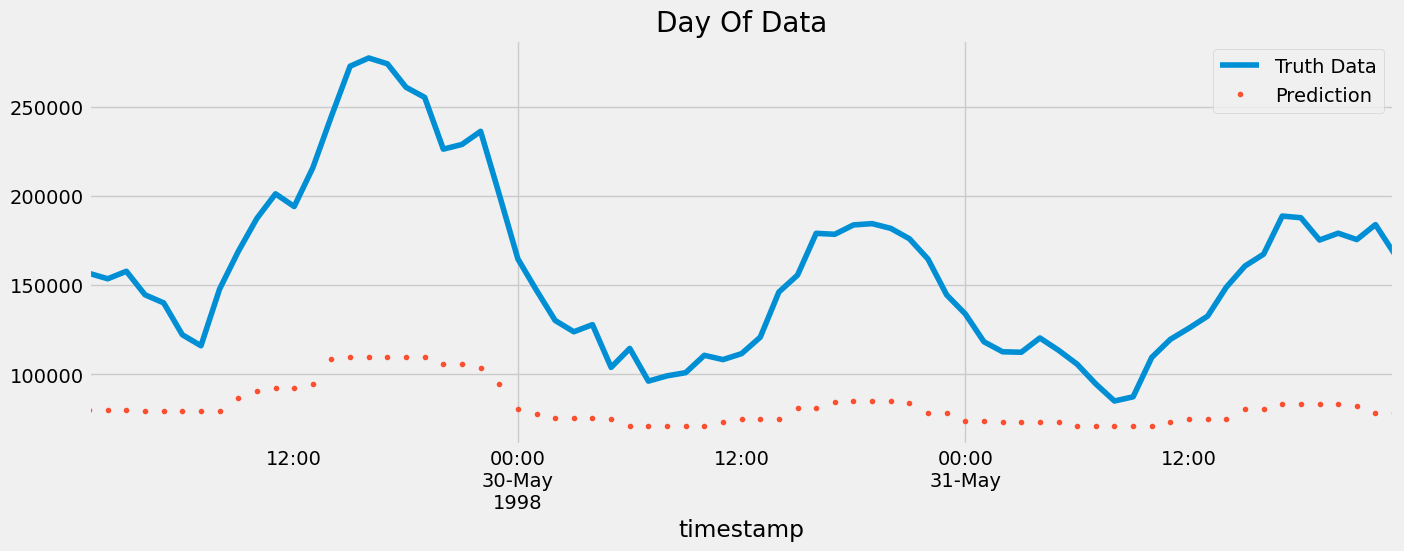

In [26]:
ax = df.loc[(df.index > '1998-05-29 00:00:00') & (df.index < '1998-06-01 00:00:00')]['total_load'] \
    .plot(figsize=(15, 5), title='Day Of Data')
df.loc[(df.index > '1998-05-29 00:00:00') & (df.index < '1998-06-01 00:00:00')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()


In [27]:
###För att kika vilka dagar som var sämst predictade

score = np.sqrt(mean_squared_error(test['total_load'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)


RMSE Score on Test set: 108695.87


date
1998-06-01    145517.781576
1998-05-29    104248.167318
1998-05-30     62439.520508
1998-05-31     61606.147135
Name: error, dtype: float64

### Skapa framtida prediktion!

In [29]:
from datetime import timedelta
last_date = historical_df.index.max().replace(hour=0, minute=0, second=0)
next_five_days_dates = pd.date_range(start=last_date+timedelta(days=1), end=last_date +timedelta(days=16), freq='T')


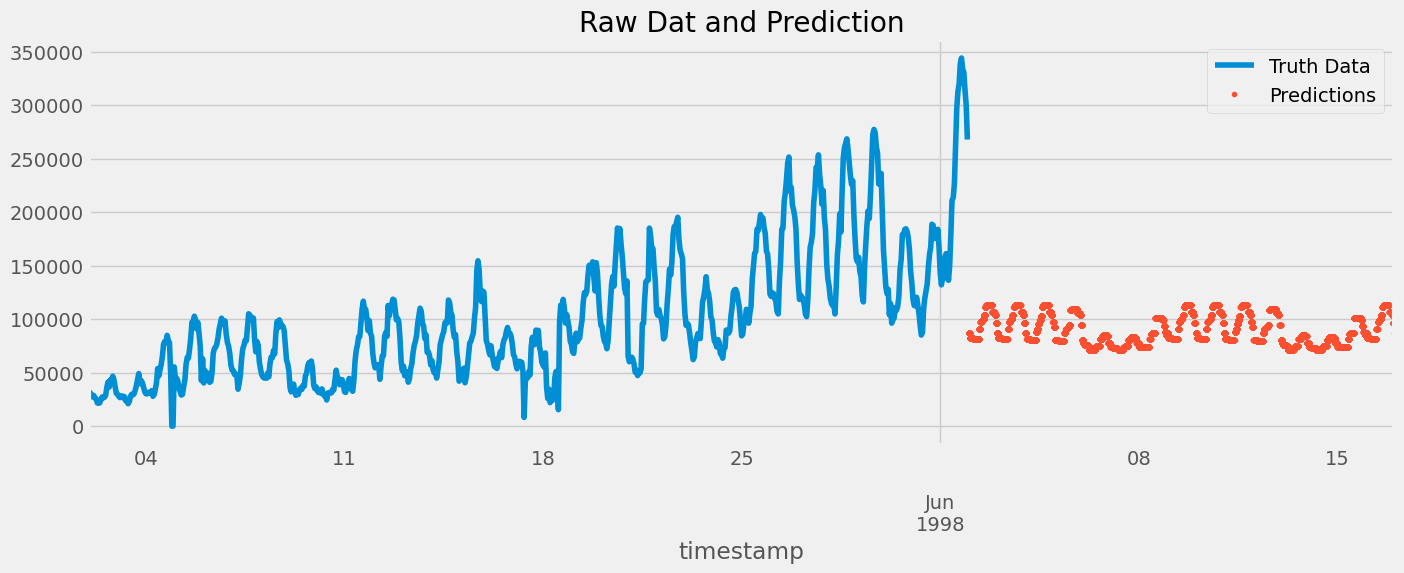

In [30]:
next_days_df = pd.DataFrame(next_five_days_dates, columns=["timestamp"])
next_days_df = next_days_df.set_index("timestamp")
next_day_test = create_features_xgboost(next_days_df)
next_days_df['prediction'] = reg.predict(next_day_test)
#df = df.merge(next_days_df[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['total_load']].plot(figsize=(15, 5))
next_days_df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

## Time series Cross Validation

In [45]:
from sklearn.model_selection import TimeSeriesSplit

In [55]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24, gap=1) #hour/dayofweek
df = df.sort_index()

df = df[df.index < "1998-06-08"] #Sen blir det för galet
df.tail()

,total_load,hour,dayofweek
timestamp,,,
1998-06-07 19:00:00,294433,19,6
1998-06-07 20:00:00,278468,20,6
1998-06-07 21:00:00,311352,21,6
1998-06-07 22:00:00,305249,22,6
1998-06-07 23:00:00,292692,23,6


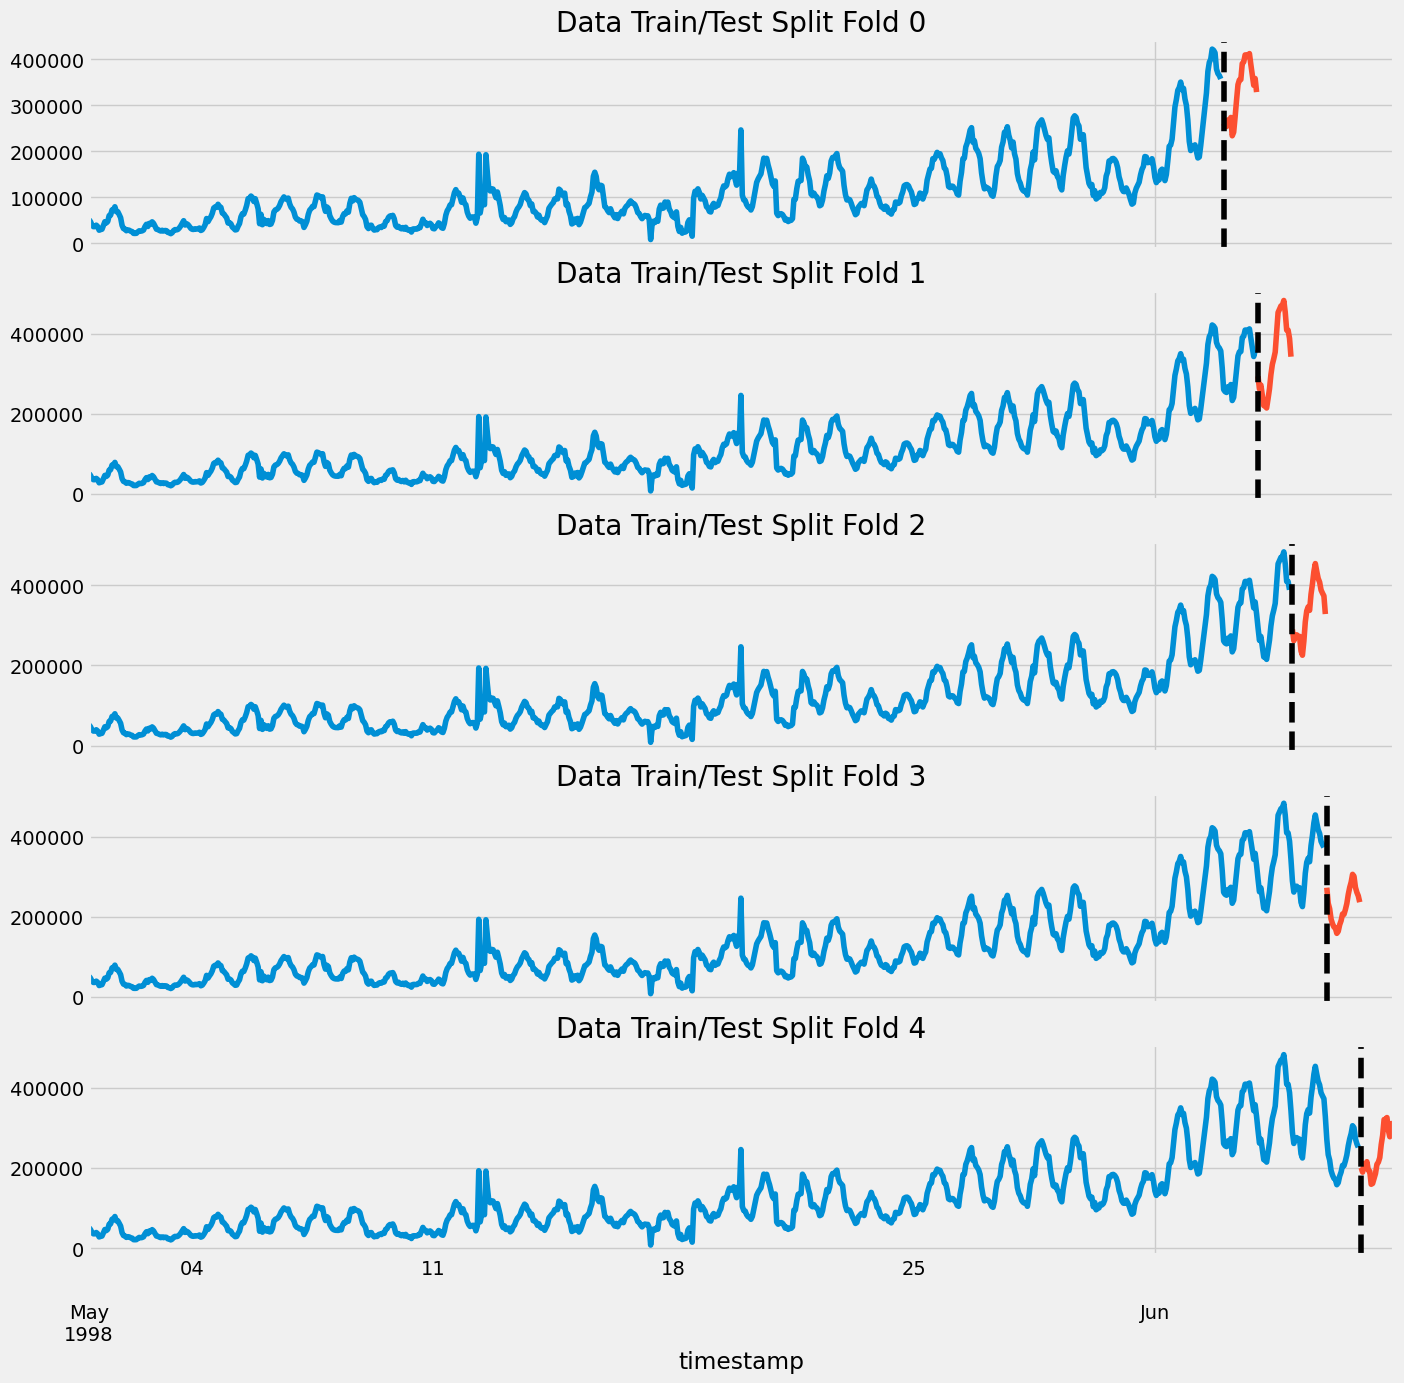

In [56]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['total_load'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['total_load'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Lag filters

Look back in to the past, use the target value for that many days in the past. What was the trarget(x) in the past?

In [57]:
def add_lags(df):
    target_map = df['total_load'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    return df
df = add_lags(df)
df

,total_load,hour,dayofweek,lag1,lag2,lag3,lag4
timestamp,,,,,,,
1998-05-01 00:00:00,51621,0,4,NaN,NaN,NaN,NaN
1998-05-01 01:00:00,46813,1,4,NaN,NaN,NaN,NaN
1998-05-01 02:00:00,39482,2,4,NaN,NaN,NaN,NaN
1998-05-01 03:00:00,36221,3,4,NaN,NaN,NaN,NaN
1998-05-01 04:00:00,36270,4,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1998-06-07 19:00:00,294433,19,6,175295.0,127748.0,84621.0,44813.0
1998-06-07 20:00:00,278468,20,6,179101.0,125085.0,89565.0,38727.0
1998-06-07 21:00:00,311352,21,6,175539.0,117607.0,74049.0,41945.0


Train using the CV and the lag filters

In [88]:
tss = TimeSeriesSplit(n_splits=10, test_size=24, gap=24)


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features_xgboost(train)
    test = create_features_xgboost(test)

    FEATURES = ['hour', 'dayofweek',
                'lag1','lag2','lag3']
    TARGET = 'total_load'
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:96351.31943	validation_1-rmse:202646.13366


[100]	validation_0-rmse:40737.67773	validation_1-rmse:98001.00070
[200]	validation_0-rmse:21843.52650	validation_1-rmse:56340.94919
[300]	validation_0-rmse:16089.76813	validation_1-rmse:42631.60004
[400]	validation_0-rmse:14097.87589	validation_1-rmse:38015.12109
[500]	validation_0-rmse:12952.14456	validation_1-rmse:36401.62173
[600]	validation_0-rmse:12215.18124	validation_1-rmse:35832.45484
[652]	validation_0-rmse:11894.85269	validation_1-rmse:35970.40597
[0]	validation_0-rmse:101414.20153	validation_1-rmse:141647.19244
[100]	validation_0-rmse:42425.82455	validation_1-rmse:58216.76441
[200]	validation_0-rmse:22456.53389	validation_1-rmse:27375.91242
[300]	validation_0-rmse:16494.16166	validation_1-rmse:16902.15217
[400]	validation_0-rmse:14270.77254	validation_1-rmse:14484.37469
[500]	validation_0-rmse:13086.03643	validation_1-rmse:13857.30684
[600]	validation_0-rmse:12365.36876	validation_1-rmse:13429.62131
[668]	validation_0-rmse:11947.38963	validation_1-rmse:13472.90971
[0]	valida

In [91]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 60247.8957
Fold scores:[35823.62403419288, 13407.57892112031, 21328.701099912367, 80213.68776246361, 107898.04560438282, 120251.23435378159, 103439.04827479698, 59742.691891783834, 24817.02954568772, 35557.31517914144]


In [97]:
mme = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_absolute_error(y_true=y_test, y_pred=y_pred)
msp = mean_absolute_percentage_error(y_test, y_pred)

print(mme,mse,msp)

35557.31517914144 29283.0673828125 11.963284066533825


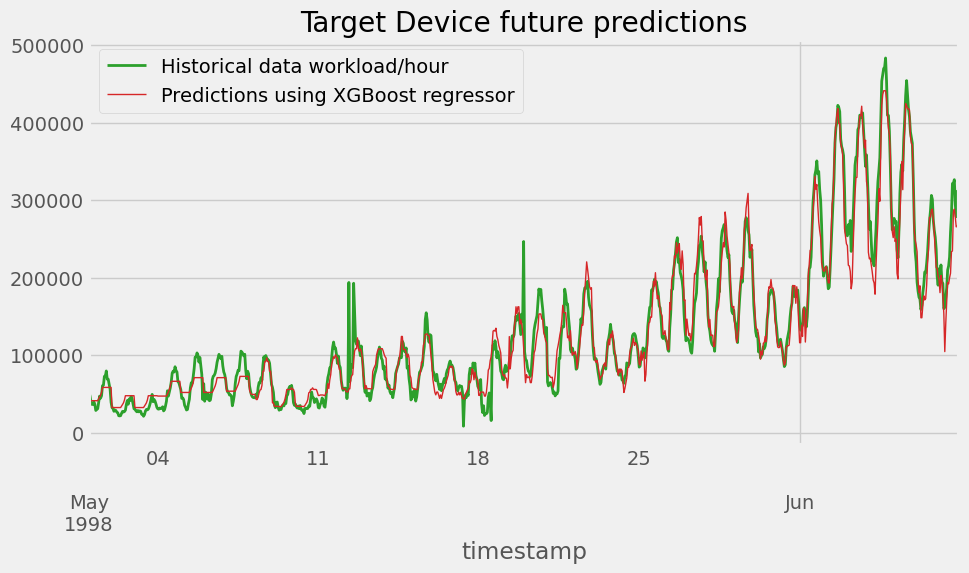

In [90]:
df['pred'] = reg.predict(df[FEATURES])


df['total_load'].plot(figsize=(10, 5),
                               color=color_pal[2],
                               ms=2,
                               lw=2,)
df['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Target Device future predictions')
plt.legend(['Historical data workload/hour ','Predictions using XGBoost regressor'])

plt.show()

## Predict the future

In [60]:
# Retrain on all data
#df = create_features_xgboost(df)

FEATURES = ['hour', 'dayofweek',
                'lag1','lag2','lag3','lag4']
TARGET = 'total_load'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=5000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:161053.33595


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [11:48:40] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:64360.98679
[200]	validation_0-rmse:30730.18032
[300]	validation_0-rmse:20581.14063
[400]	validation_0-rmse:17564.01743
[500]	validation_0-rmse:16501.96822
[600]	validation_0-rmse:15720.37830
[700]	validation_0-rmse:14994.72334
[800]	validation_0-rmse:14578.25799
[900]	validation_0-rmse:14192.03700
[1000]	validation_0-rmse:13788.99899
[1100]	validation_0-rmse:13418.15690
[1200]	validation_0-rmse:13105.51311
[1300]	validation_0-rmse:12794.86691
[1400]	validation_0-rmse:12519.66165
[1500]	validation_0-rmse:12278.17968
[1600]	validation_0-rmse:11988.11823
[1700]	validation_0-rmse:11759.65970
[1800]	validation_0-rmse:11529.95939
[1900]	validation_0-rmse:11248.89571
[2000]	validation_0-rmse:11010.64174
[2100]	validation_0-rmse:10801.14870
[2200]	validation_0-rmse:10571.05811
[2300]	validation_0-rmse:10368.18111
[2400]	validation_0-rmse:10205.27270
[2500]	validation_0-rmse:10040.52994
[2600]	validation_0-rmse:9846.60563
[2700]	validation_0-rmse:9660.30897
[2800]	valid

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [65]:
df.index.max()
# Create future dataframe
future = pd.date_range('1998-06-07 23:00:00','1998-06-14 00:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features_xgboost(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()
future_w_features
df_and_future


,total_load,hour,dayofweek,lag1,lag2,lag3,lag4,isFuture
1998-05-01 00:00:00,51621.0,0,4,NaN,NaN,NaN,NaN,False
1998-05-01 01:00:00,46813.0,1,4,NaN,NaN,NaN,NaN,False
1998-05-01 02:00:00,39482.0,2,4,NaN,NaN,NaN,NaN,False
1998-05-01 03:00:00,36221.0,3,4,NaN,NaN,NaN,NaN,False
1998-05-01 04:00:00,36270.0,4,4,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...
1998-06-13 20:00:00,NaN,20,5,273568.0,181822.0,124229.0,86819.0,True
1998-06-13 21:00:00,NaN,21,5,260998.0,176005.0,116394.0,83934.0,True
1998-06-13 22:00:00,NaN,22,5,252142.0,164585.0,102141.0,76873.0,True
1998-06-13 23:00:00,NaN,23,5,236466.0,144535.0,99149.0,66782.0,True


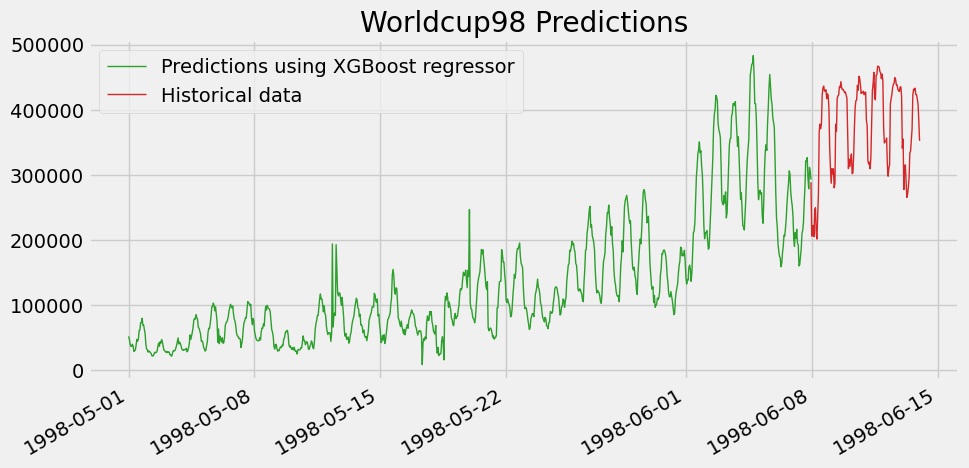

In [66]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])



df_and_future['total_load'].plot(figsize=(10, 5),
                               color=color_pal[2],
                               ms=1,
                               lw=1,)
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Worldcup98 Predictions')

plt.legend(['Predictions using XGBoost regressor','Historical data'])

plt.show()

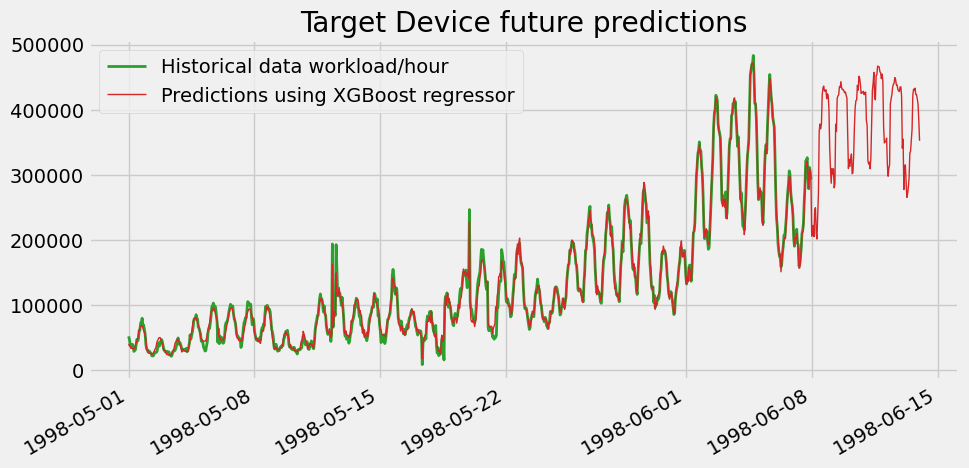

In [67]:
df_and_future['pred'] = reg.predict(df_and_future[FEATURES])


df_and_future['total_load'].plot(figsize=(10, 5),
                               color=color_pal[2],
                               ms=2,
                               lw=2,)
df_and_future['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Target Device future predictions')
plt.legend(['Historical data workload/hour ','Predictions using XGBoost regressor'])

plt.show()


# Prophet prediction algoritm

In [93]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

#Easier to undestand - gives th aarage percent off what our prediction is from the ground truth.
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [74]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    X = df[['hour','dayofweek','weekday',
           ]]
    if label:
        y = df[label]
        return X, y
    return X

hourly_sum = hourly_sum[hourly_sum.index<"1998-06-08"]
X, y = create_features(hourly_sum, label='total_load')
features_and_target = pd.concat([X, y], axis=1)
features_and_target

,hour,dayofweek,weekday,total_load
timestamp,,,,
1998-05-01 00:00:00,0,4,Friday,51621
1998-05-01 01:00:00,1,4,Friday,46813
1998-05-01 02:00:00,2,4,Friday,39482
1998-05-01 03:00:00,3,4,Friday,36221
1998-05-01 04:00:00,4,4,Friday,36270
...,...,...,...,...
1998-06-07 19:00:00,19,6,Sunday,294433
1998-06-07 20:00:00,20,6,Sunday,278468
1998-06-07 21:00:00,21,6,Sunday,311352


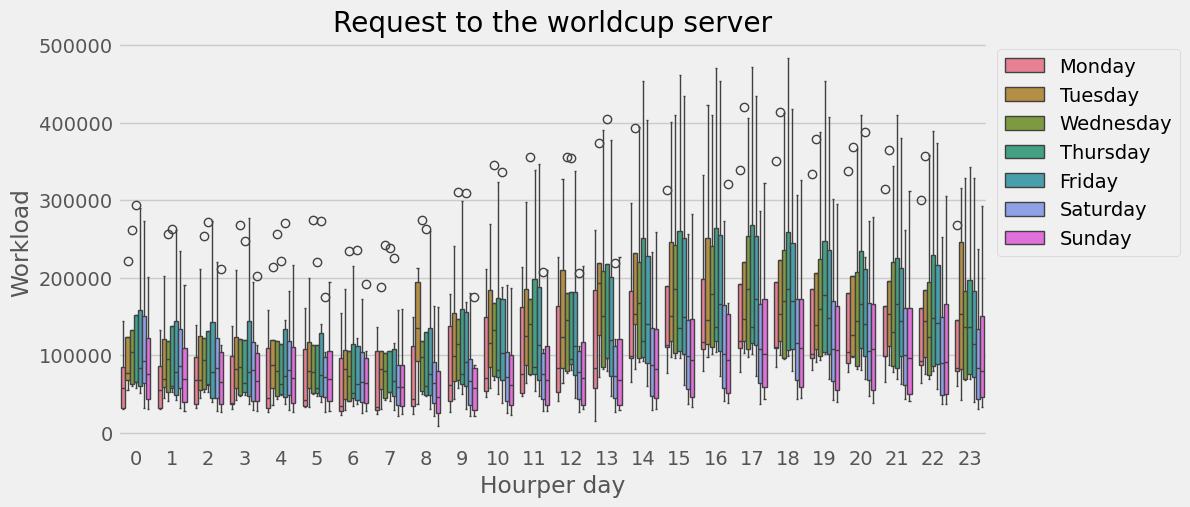

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='hour',
            y='total_load',
            hue='weekday',
            ax=ax,
            linewidth=1)
ax.set_title('Request to the worldcup server')
ax.set_xlabel('Hourper day')
ax.set_ylabel('Workload')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### Train/Test split

In [76]:
def add_lags_prophet(df):
    target_map = df['total_load'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    return df
df_filtered_prophet = add_lags_prophet(features_and_target)
df_filtered_prophet

,hour,dayofweek,weekday,total_load,lag1,lag2,lag3
timestamp,,,,,,,
1998-05-01 00:00:00,0,4,Friday,51621,NaN,NaN,NaN
1998-05-01 01:00:00,1,4,Friday,46813,NaN,NaN,NaN
1998-05-01 02:00:00,2,4,Friday,39482,NaN,NaN,NaN
1998-05-01 03:00:00,3,4,Friday,36221,NaN,NaN,NaN
1998-05-01 04:00:00,4,4,Friday,36270,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1998-06-07 19:00:00,19,6,Sunday,294433,175295.0,127748.0,84621.0
1998-06-07 20:00:00,20,6,Sunday,278468,179101.0,125085.0,89565.0
1998-06-07 21:00:00,21,6,Sunday,311352,175539.0,117607.0,74049.0


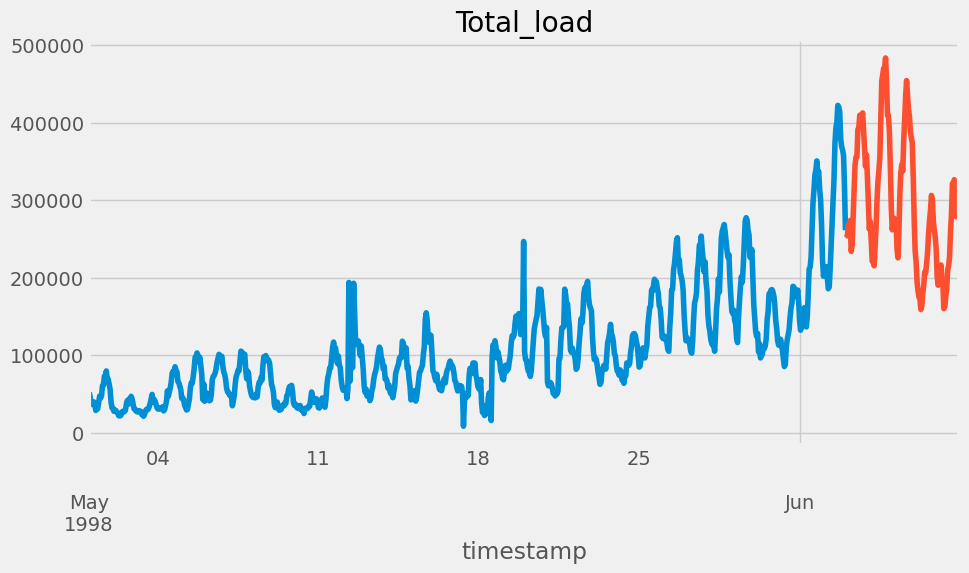

In [78]:
# Assuming targetdevice_train and targetdevice_test are DataFrames
split_date = '03-Jun-1998'
targetdevice_train = df_filtered_prophet.loc[df_filtered_prophet.index <= split_date].copy()
targetdevice_test = df_filtered_prophet.loc[df_filtered_prophet.index > split_date].copy()

# Plot train and test so you can see where we have split
merged_df = targetdevice_test.rename(columns={'total_load': 'TEST SET'}) \
    .join(targetdevice_train.rename(columns={'total_load': 'TRAINING SET'}),
          how='outer', lsuffix='_test', rsuffix='_train')  # Specify suffixes
merged_df["TRAINING SET"].plot(figsize=(10, 5), title='Total_load', ms=1)
merged_df["TEST SET"].plot(figsize=(10, 5), title='Total_load', ms=1)
plt.show()

## Simple Prophet Model
 Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
 Datetime column named: ds
 target : y

In [79]:
# Format data for prophet model using ds and y
targetdevice_train_prophet = targetdevice_train.reset_index() \
    .rename(columns={'timestamp':'ds',
                     'total_load':'y'})
targetdevice_train_prophet

,ds,hour,dayofweek,weekday,y,lag1,lag2,lag3
0,1998-05-01 00:00:00,0,4,Friday,51621,NaN,NaN,NaN
1,1998-05-01 01:00:00,1,4,Friday,46813,NaN,NaN,NaN
2,1998-05-01 02:00:00,2,4,Friday,39482,NaN,NaN,NaN
3,1998-05-01 03:00:00,3,4,Friday,36221,NaN,NaN,NaN
4,1998-05-01 04:00:00,4,4,Friday,36270,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
788,1998-06-02 20:00:00,20,1,Tuesday,369131,201945.0,126394.0,99217.0
789,1998-06-02 21:00:00,21,1,Tuesday,364757,195608.0,152733.0,111647.0
790,1998-06-02 22:00:00,22,1,Tuesday,357404,184086.0,143834.0,97419.0
791,1998-06-02 23:00:00,23,1,Tuesday,315548,153090.0,246517.0,81991.0


### Create model

In [80]:

model = Prophet()
model.fit(targetdevice_train_prophet)

11:53:23 - cmdstanpy - INFO - Chain [1] start processing
11:53:24 - cmdstanpy - INFO - Chain [1] done processing


In [81]:
# Predict on test set with model
targetdevice_test_prophet = targetdevice_test.reset_index() \
    .rename(columns={'timestamp':'ds',
                     'total_load':'y'})
targetdevice_test_fcst = model.predict(targetdevice_test_prophet)
targetdevice_test_fcst.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1998-06-03 01:00:00,246915.133600,217984.516186,284638.883537,246915.133600,246915.133600,4544.669855,4544.669855,4544.669855,-23680.763899,-23680.763899,-23680.763899,28225.433755,28225.433755,28225.433755,0.0,0.0,0.0,251459.803455
1,1998-06-03 02:00:00,247496.708103,216139.983117,279768.401677,247496.708103,247496.708103,201.728728,201.728728,201.728728,-27088.365906,-27088.365906,-27088.365906,27290.094634,27290.094634,27290.094634,0.0,0.0,0.0,247698.436831
2,1998-06-03 03:00:00,248078.282606,213305.082833,278757.685412,248078.282606,248078.282606,-395.062122,-395.062122,-395.062122,-26680.917116,-26680.917116,-26680.917116,26285.854994,26285.854994,26285.854994,0.0,0.0,0.0,247683.220485
3,1998-06-03 04:00:00,248659.857109,215390.798844,278569.997731,248659.857109,248659.857109,-2205.316664,-2205.316664,-2205.316664,-27426.052831,-27426.052831,-27426.052831,25220.736166,25220.736166,25220.736166,0.0,0.0,0.0,246454.540445
4,1998-06-03 05:00:00,249241.431613,209230.671882,274474.069899,249241.431613,249241.431613,-7438.648728,-7438.648728,-7438.648728,-31541.815592,-31541.815592,-31541.815592,24103.166864,24103.166864,24103.166864,0.0,0.0,0.0,241802.782884


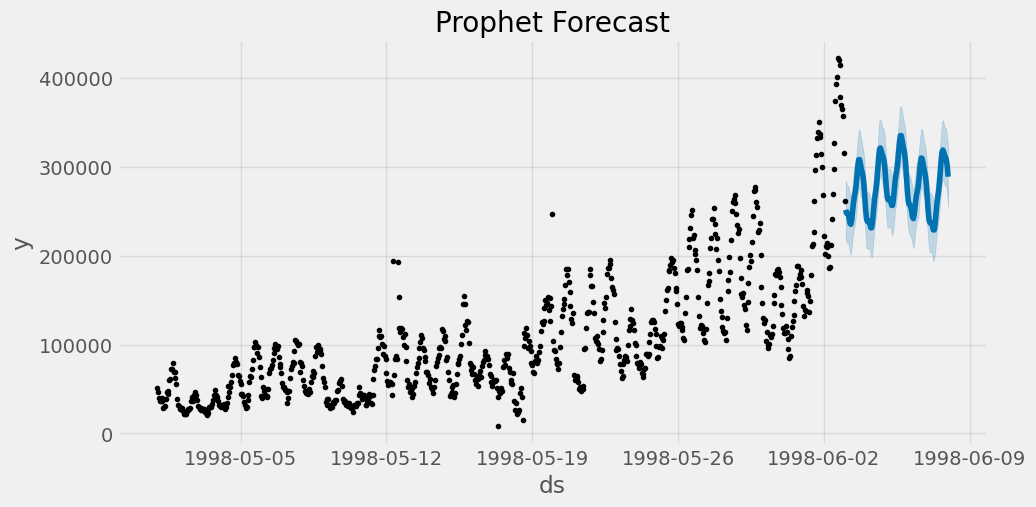

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(targetdevice_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

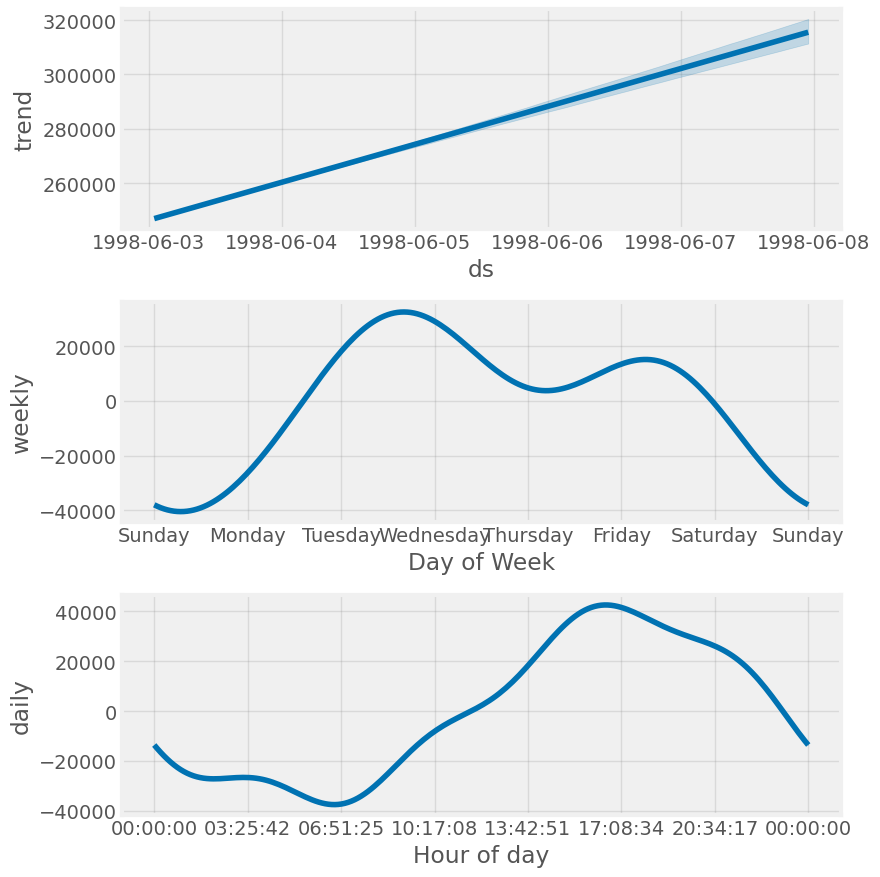

In [83]:
fig = model.plot_components(targetdevice_test_fcst)
plt.show()


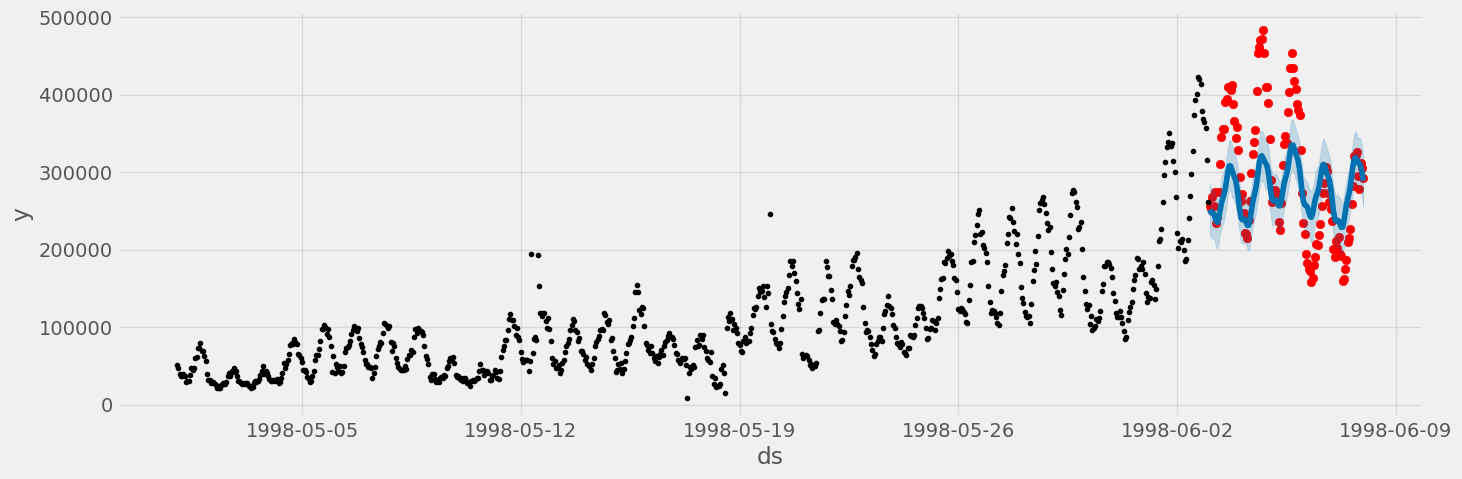

In [84]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(targetdevice_test.index, targetdevice_test['total_load'], color='r')
fig = model.plot(targetdevice_test_fcst, ax=ax)



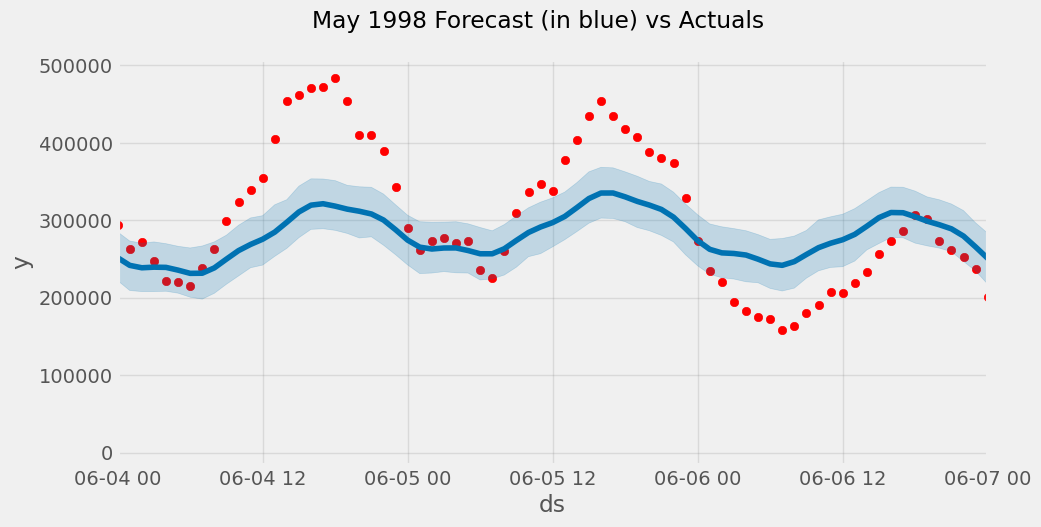

In [87]:
#targetdevice_test.index = pd.to_datetime(targetdevice_test.index)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(targetdevice_test.index, targetdevice_test['total_load'], color='r')
fig = model.plot(targetdevice_test_fcst, ax=ax)
lower_date = pd.to_datetime('1998-06-04')
upper_date = pd.to_datetime('1998-06-07')

ax.set_xbound(lower=lower_date, upper=upper_date)
plot = plt.suptitle('May 1998 Forecast (in blue) vs Actuals')

## Evaluation of the model 

In [68]:
mme = np.sqrt(mean_squared_error(y_true=targetdevice_test['total_load'],
                   y_pred=targetdevice_test_fcst['yhat']))

mse = mean_absolute_error(y_true=targetdevice_test['total_load'],
                   y_pred=targetdevice_test_fcst['yhat'])

msp = mean_absolute_percentage_error(y_true=targetdevice_test['total_load'],
                   y_pred=targetdevice_test_fcst['yhat'])

print(mme,mse,msp)

44542.85322454597 39266.023730653964 26.324636787813144


# Här kommer kod sen innan! Allt ovanför följer youtube tutorials

In [200]:
#Small effort do delete outliers
# calculate summary statistics
data_mean, data_std = mean(historical_df["total_load"]), std(historical_df["total_load"])
cut_off = data_std * 1 #Räknas som outliers om de är mer än 2 standard deviations från medelvärdet. 
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower,upper)
print(data_mean)

outliers = [x for x in historical_df["total_load"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
...
outliers_removed = [x for x in historical_df["total_load"] if x > lower and x < upper]
print(len(outliers_removed))
historical_df_outliers_removed = historical_df[(historical_df["total_load"] > lower) & (historical_df["total_load"] < upper)]


179.79130785156258 1930.7323596847773
1055.26183376817
Identified outliers: 1017
20447


In [248]:
X = historical_df['timestamp'].astype(int).values.reshape(-1, 1)
y = historical_df['total_load'].values.reshape(-1, 1)
print(X,y)

[[894067200000000000]
 [894067260000000000]
 [894067320000000000]
 ...
 [895363020000000000]
 [895363080000000000]
 [895363140000000000]] [[ 352]
 [ 373]
 [ 401]
 ...
 [ 957]
 [1252]
 [ 987]]


In [85]:
##Scale the data. This part doesnt work as expected.

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
print(X,y)

[[-1.73557606]
 [-1.73535727]
 [-1.73513848]
 ...
 [ 1.72934782]
 [ 1.7295666 ]
 [ 1.72978539]] [[-1.27776128]
 [-1.23208847]
 [-1.17119138]
 ...
 [ 0.89713476]
 [ 0.75794141]
 [ 0.29468856]]


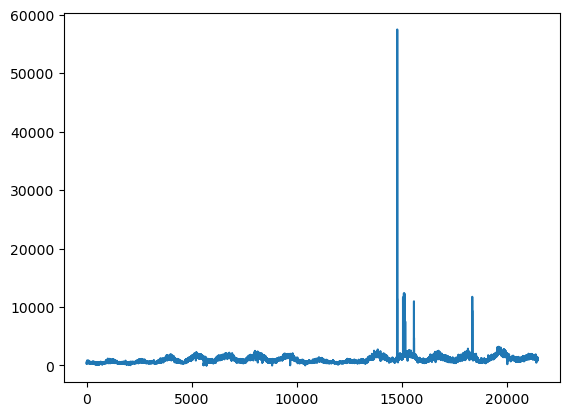

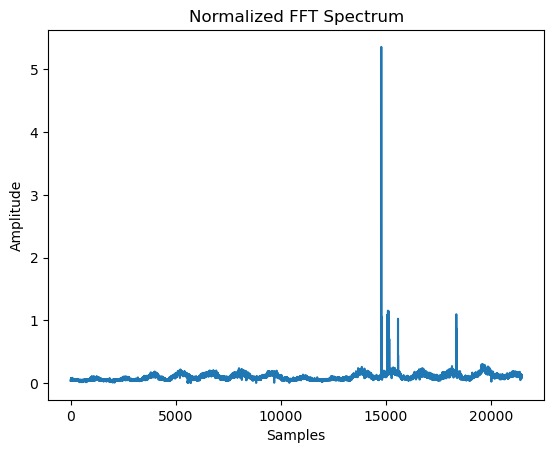

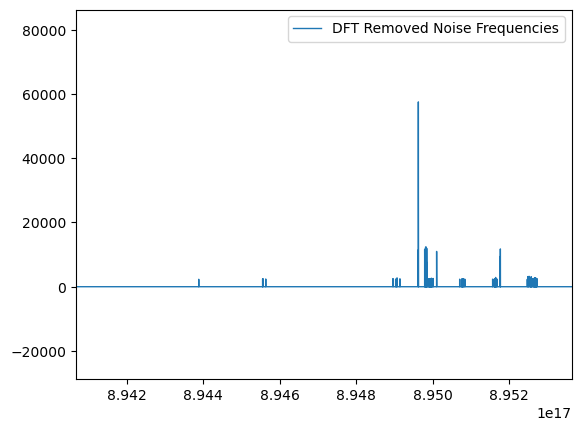

In [250]:
##Fourier aproximation FUNKAR EJ
# Apply the FFT on the signal
fourier = fft(y)

# Plot the result (the spectrum |Xk|)
plt.plot(np.abs(fourier))
plt.show()

N = len(y)
normalize = N/2

# Plot the normalized FFT (|Xk|)/(N/2)
plt.plot(np.abs(fourier)/normalize)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Normalized FFT Spectrum')
plt.show()

yf_abs      = np.abs(y) 
indices     = yf_abs>2300   # filter out those value under 300
yfClean    = indices * y # noise frequency will be set to 0
plt.plot(X,np.abs(yfClean),linewidth=1,label="DFT Removed Noise Frequencies")
plt.margins(x=0, y=0.5)
plt.legend()
plt.show()


In [223]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=(0.2/0.9), random_state=42) #Taget från intelligenta

In [204]:
# Model Evaluation
##Linear regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 151212.3521888552


In [32]:
#Support vector machines
# Train SVR model with polynomial kernel
poly_svr = make_pipeline(StandardScaler(), SVR(kernel='poly', degree=5, C=100, gamma="auto", epsilon=0.1, coef0=1))  # Adjust degree as needed
poly_svr.fit(X_train, y_train)
# Predict workload
y_pred = poly_svr.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 132627.36284775936


In [67]:

# Initialize variables to store best degree and corresponding MSE
best_degree = None
best_mse = float('inf')  # Initialize with a large value

# Try different degrees
for degree in range(1, 6):  # Try degrees 1 to 5
    # Train SVR model with polynomial kernel
    poly_svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', degree=degree))
    poly_svr.fit(X_train, y_train)

    # Predict workload on validation set
    y_pred = poly_svr.predict(X_val)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_val, y_pred)

    # Check if current degree gives lower MSE
    if mse < best_mse:
        best_mse = mse
        best_degree = degree

# Print the best degree and corresponding MSE
print("Best Degree:", best_degree)
print("Best MSE:", best_mse)

Best Degree: 1
Best MSE: 141895.00995225305


In [225]:
## Trying SVM with regression 
svr = SVR(C=1.0, epsilon=0.2).fit(X_train, y_train)
# Predict workload
y_pred = svr.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
score = svr.score(X,y)
print("R-squared:", score)


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 188461.48591859464


ValueError: X has 1 features, but SVR is expecting 100 features as input.

SVR()


In [139]:
## Decision Tree
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_tree)
print("Mean Squared Error:", mse)


Mean Squared Error: 22814.734977139124


In [140]:
## Random Forests
forest_model = RandomForestRegressor(max_depth= 10,min_samples_leaf = 1, min_samples_split = 10, n_estimators = 300)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_forest)
print("Mean Squared Error:", mse)

/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 22569.017421441826


In [ ]:
# parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],        # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required to be at a leaf node
}

forest_model = RandomForestRegressor()

grid_search = GridSearchCV(forest_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_forest_model = grid_search.best_estimator_
y_pred_forest = best_forest_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_forest)
print("Mean Squared Error:", mse)

print("Best Parameters:", grid_search.best_params_)

Mean Squared Error: 183.56072563159594
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [138]:

## Gradient Boosting
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_gbm)
print("Mean Squared Error:", mse)

/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Mean Squared Error: 24500.401071219083


In [112]:
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train, y_train)
y_pred = knn_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
hyperparameters = {'n_neighbors': np.arange(1,30,1)}


Mean Squared Error: 16951.350847337446


In [219]:
last_date = historical_df_outliers_removed['timestamp'].max()
first_date = historical_df_outliers_removed['timestamp'].min()
next_day = last_date + pd.DateOffset(days=1)

#Prepare next day timestamps, starting from the beginning of the next day 
next_day_timestamps = pd.date_range(start=next_day.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
all_days= pd.date_range(start=first_date.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
print(next_day_timestamps)
print(all_days)

DatetimeIndex(['1998-05-17 00:00:00', '1998-05-17 00:01:00',
               '1998-05-17 00:02:00', '1998-05-17 00:03:00',
               '1998-05-17 00:04:00', '1998-05-17 00:05:00',
               '1998-05-17 00:06:00', '1998-05-17 00:07:00',
               '1998-05-17 00:08:00', '1998-05-17 00:09:00',
               ...
               '1998-05-18 23:50:00', '1998-05-18 23:51:00',
               '1998-05-18 23:52:00', '1998-05-18 23:53:00',
               '1998-05-18 23:54:00', '1998-05-18 23:55:00',
               '1998-05-18 23:56:00', '1998-05-18 23:57:00',
               '1998-05-18 23:58:00', '1998-05-18 23:59:00'],
              dtype='datetime64[ns]', length=2880, freq='T')
DatetimeIndex(['1998-05-02 00:00:00', '1998-05-02 00:01:00',
               '1998-05-02 00:02:00', '1998-05-02 00:03:00',
               '1998-05-02 00:04:00', '1998-05-02 00:05:00',
               '1998-05-02 00:06:00', '1998-05-02 00:07:00',
               '1998-05-02 00:08:00', '1998-05-02 00:09:00',
    

In [220]:
next_day_predictions = model.predict(next_day_timestamps.astype(int).values.reshape(-1, 1))  # Use your model to predict workload for next_day_timestamps
all_day_predictions = svr.predict(all_days.astype(int).values.reshape(-1, 1))
print(all_day_predictions)


[ 473.70145474  473.72024949  473.73908263 ... 1036.21991117 1036.17872824
 1036.13754962]


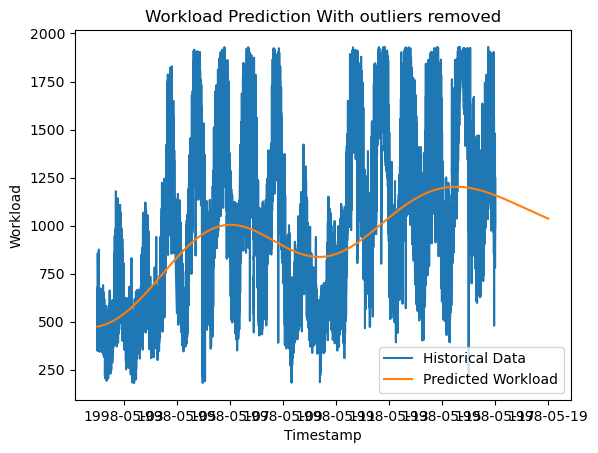

In [221]:
plt.plot(historical_df_outliers_removed['timestamp'], historical_df_outliers_removed['total_load'], label='Historical Data')

plt.plot(all_days, all_day_predictions, label='Predicted Workload')
plt.xlabel('Timestamp')
plt.ylabel('Workload')
plt.title('Workload Prediction With outliers removed')
plt.legend()
plt.show()

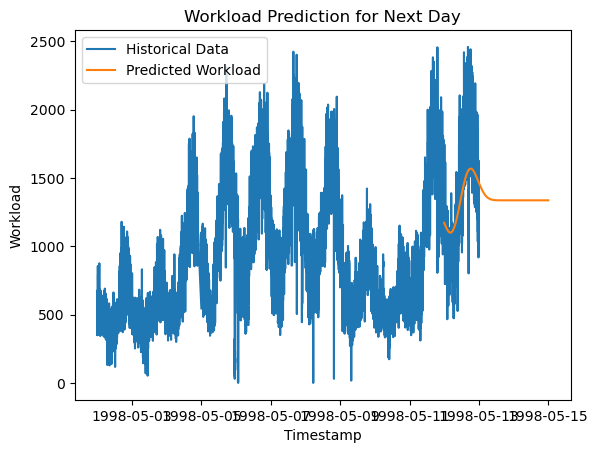

In [27]:
five_fays = first_date + pd.DateOffset(days=10)
last_five_days= pd.date_range(start=five_fays.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
last_five_days_predictions = svr.predict(last_five_days.astype(int).values.reshape(-1, 1))

plt.plot(historical_df['timestamp'], historical_df['total_load'], label='Historical Data')

plt.plot(last_five_days, last_five_days_predictions, label='Predicted Workload')
plt.xlabel('Timestamp')
plt.ylabel('Workload')
plt.title('Workload Prediction for Next Day')
plt.legend()
plt.show()